Another approach: 

* include the other 3 variables including the year, temp (shift to t+1), month_sin, month_cos
* Do the early stopping where the validation is minimum. 
* plot the residual 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.python import keras
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
import tensorflow as tf
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

np.random.seed(7)

In [9]:
path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\geopy\france_cleaned"

region = "Alsace.csv"
region_name = region.split('.')[0]
df = pd.read_csv(path+'\\'+region)


In [10]:
def make_cyclic_sin(month):
    a = np.sin((month-1)*(2.*np.pi/12))
    return a
def make_cyclic_cos(month):
    b = np.cos((month-1)*(2.*np.pi/12))
    return b 

In [11]:
temp_df = df[df['PARAMETER'] == 'T2M']
temp_df = temp_df.drop('ANN', axis = 1)
#hum_df = data[data['PARAMETER'] == 'RH2M']

In [12]:
temp_df = temp_df.rename(columns = {'YEAR':'year','JAN':1, 'FEB':2,'MAR':3, 'APR':4, 'MAY':5,'JUN':6,
                         'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12})
temp_df = temp_df.drop(['PARAMETER','LAT','LON'], axis = 1)

temp_df.set_index('year', inplace = True)
df = pd.concat([temp_df.stack()], axis=1)
df.reset_index(inplace = True)

df.rename(columns = {'level_1':'month',0:'avg_temp'}, inplace = True)

# encoding for months 
#cyclic encoding from deep learning notebook
df['month_sin'] = df['month'].apply(lambda row: make_cyclic_sin(row))
df['month_cos'] = df['month'].apply(lambda row: make_cyclic_cos(row))

df['date'] = df[['year','month']].astype(str).apply('-'.join, axis=1)

df.date = pd.to_datetime(df.date)
df = df.set_index('date')

In [13]:
df.head()

,year,month,avg_temp,month_sin,month_cos
date,,,,,
1981-01-01,1981,1,-2.68,0.000000,1.000000e+00
1981-02-01,1981,2,-1.23,0.500000,8.660254e-01
1981-03-01,1981,3,6.74,0.866025,5.000000e-01
1981-04-01,1981,4,8.99,1.000000,6.123234e-17
1981-05-01,1981,5,12.46,0.866025,-5.000000e-01


In [14]:
# add the unlablled data
unlabelled_dataset = pd.read_excel('to_predict_mult.xlsx')
unlabelled_dataset['date'] = unlabelled_dataset[['year','month']].astype(str).apply('-'.join, axis=1)
unlabelled_dataset.date = pd.to_datetime(unlabelled_dataset.date)
unlabelled_dataset = unlabelled_dataset.set_index('date')
unlabelled_dataset.head()

,year,avg_temp,month,month_sin,month_cos
date,,,,,
2020-01-01,2020,NaN,1,0.000000,1.000000e+00
2020-02-01,2020,NaN,2,0.500000,8.660254e-01
2020-03-01,2020,NaN,3,0.866025,5.000000e-01
2020-04-01,2020,NaN,4,1.000000,6.123234e-17
2020-05-01,2020,NaN,5,0.866025,-5.000000e-01


In [15]:
# combine all the data and divide
df = df[['year','avg_temp','month_sin','month_cos']]
unlabelled_dataset = unlabelled_dataset[['year','avg_temp','month_sin','month_cos']]
# fit_transform all the data including the train, valid, and test 
combined_data = pd.concat([df,unlabelled_dataset])

In [16]:
# shifting the avg_temp to t+1 
combined_data['avg_temp'] = combined_data['avg_temp'].shift(1)

In [17]:
combined_data

,year,avg_temp,month_sin,month_cos
date,,,,
1981-01-01,1981,NaN,0.000000e+00,1.000000e+00
1981-02-01,1981,-2.68,5.000000e-01,8.660254e-01
1981-03-01,1981,-1.23,8.660254e-01,5.000000e-01
1981-04-01,1981,6.74,1.000000e+00,6.123234e-17
1981-05-01,1981,8.99,8.660254e-01,-5.000000e-01
1981-06-01,1981,12.46,5.000000e-01,-8.660254e-01
1981-07-01,1981,15.47,1.224647e-16,-1.000000e+00
1981-08-01,1981,16.75,-5.000000e-01,-8.660254e-01
1981-09-01,1981,17.32,-8.660254e-01,-5.000000e-01


In [18]:
# removing the nan value
scaler = MinMaxScaler()
combined_data = combined_data[1:]
combined_data[['year','avg_temp','month_sin','month_cos']] = scaler.fit_transform(combined_data)

In [20]:
data = combined_data[0:467] # all the labelled data

In [22]:
data.tail()

,year,avg_temp,month_sin,month_cos
date,,,,
2019-08-01,0.95,0.899836,0.250000,0.066987
2019-09-01,0.95,0.869394,0.066987,0.250000
2019-10-01,0.95,0.715548,0.000000,0.500000
2019-11-01,0.95,0.589525,0.066987,0.750000
2019-12-01,0.95,0.364648,0.250000,0.933013


In [23]:
# 80 percent for the training set and 20 percent for the validation on the labelled data
y = data.avg_temp
X = data
valid_and_test_size = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_and_test_size*2, random_state=42, shuffle=False)

In [25]:
print(X_train.shape) #1981-02
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(373, 4)
(373,)
(94, 4)
(94,)


In [26]:
X_train.head()

,year,avg_temp,month_sin,month_cos
date,,,,
1981-02-01,0.0,0.126350,0.750000,0.933013
1981-03-01,0.0,0.173813,0.933013,0.750000
1981-04-01,0.0,0.434697,1.000000,0.500000
1981-05-01,0.0,0.508347,0.933013,0.250000
1981-06-01,0.0,0.621931,0.750000,0.066987


In [27]:
# from series convert to array
y_train = y_train.values.reshape(len(y_train),1)
#y_test = y_test.values.reshape(len(y_test),1)
y_valid = y_valid.values.reshape(len(y_valid),1)

In [28]:
X_train.tail()

,year,avg_temp,month_sin,month_cos
date,,,,
2011-10-01,0.750,0.747300,0.000000,0.500000
2011-11-01,0.750,0.532242,0.066987,0.750000
2011-12-01,0.750,0.391489,0.250000,0.933013
2012-01-01,0.775,0.316530,0.500000,1.000000
2012-02-01,0.775,0.270704,0.750000,0.933013


In [29]:
X_valid.tail()

,year,avg_temp,month_sin,month_cos
date,,,,
2019-08-01,0.95,0.899836,0.250000,0.066987
2019-09-01,0.95,0.869394,0.066987,0.250000
2019-10-01,0.95,0.715548,0.000000,0.500000
2019-11-01,0.95,0.589525,0.066987,0.750000
2019-12-01,0.95,0.364648,0.250000,0.933013


In [30]:
y_valid.shape

(94, 1)

In [31]:
look_back=12
FORECAST_DISTANCE=1 # forecast on the next month
n_features = len(X_train.columns)


In [32]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

In [33]:
segmenter = SegmentXYForecast(width=look_back, step=1, y_func=last, forecast=FORECAST_DISTANCE) 

In [34]:
X_train

,year,avg_temp,month_sin,month_cos
date,,,,
1981-02-01,0.000,0.126350,0.750000,0.933013
1981-03-01,0.000,0.173813,0.933013,0.750000
1981-04-01,0.000,0.434697,1.000000,0.500000
1981-05-01,0.000,0.508347,0.933013,0.250000
1981-06-01,0.000,0.621931,0.750000,0.066987
1981-07-01,0.000,0.720458,0.500000,0.000000
1981-08-01,0.000,0.762357,0.250000,0.066987
1981-09-01,0.000,0.781015,0.066987,0.250000
1981-10-01,0.000,0.693290,0.000000,0.500000


In [35]:
# the segmenter will segment the data according to the parameters set.
X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values],[y_train.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values],[y_valid.flatten()])

In [36]:
X_train_rolled.shape

(361, 12, 4)

In [37]:
BATCH_SIZE = 5
EPOCHS = 30
DROPOUT_RATE= 0.01
LSTM_UNIT_SIZE = 5

# Build the model 
model = Sequential()
model.add(LSTM(LSTM_UNIT_SIZE, activation = 'relu',input_shape = (look_back, n_features)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1))


#compile the model
model.compile(optimizer = 'adam', loss = 'mse')

# fit the model

model_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
mc = ModelCheckpoint(model_path+f'{region_name}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
                    
history = model.fit(X_train_rolled, y_train_rolled, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_valid_rolled,y_valid_rolled), callbacks = [es,mc]) #, callbacks = es

Train on 361 samples, validate on 82 samples
Epoch 1/30
361/361 [==============================] - 2s 4ms/step - loss: 0.1946 - val_loss: 0.1105

Epoch 00001: val_loss improved from inf to 0.11055, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\Alsace.h5
Epoch 2/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0757 - val_loss: 0.0625

Epoch 00002: val_loss improved from 0.11055 to 0.06249, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\Alsace.h5
Epoch 3/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0587 - val_loss: 0.0469

Epoch 00003: val_loss improved from 0.06249 to 0.04686, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\Alsace.h5
Epoch 4/30
361/361 [=====================

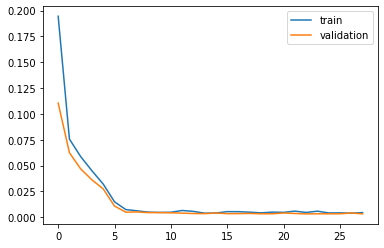

In [38]:
eval_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France evaluation\\"

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.savefig(eval_path+f'{region_name} evaluation.png')
plt.show()



In [39]:
# get the saved model 
saved_model = load_model(model_path+f'{region_name}.h5')
print('Model name: ',region_name+'.h5')

Model name:  Alsace.h5


## Predicting the training and getting the inverse

In [40]:
train_y_hat = saved_model.predict(X_train_rolled) 

In [41]:
train_y_hat = pd.DataFrame(train_y_hat)

In [42]:
train_y_hat = train_y_hat.rename(columns = {0:'y_hat'})

In [43]:
for_inverse_scaling = combined_data[12:373]
#combined_data['ss'] = scaler.inverse_transform(train_predict)

In [44]:
for_inverse_scaling.head()

,year,avg_temp,month_sin,month_cos
date,,,,
1982-02-01,0.025,0.194108,0.750000,0.933013
1982-03-01,0.025,0.245172,0.933013,0.750000
1982-04-01,0.025,0.336170,1.000000,0.500000
1982-05-01,0.025,0.429460,0.933013,0.250000
1982-06-01,0.025,0.632406,0.750000,0.066987


In [45]:
for_inverse_scaling['y_hat_train'] = train_y_hat['y_hat'].values
for_inverse_scaling_x = for_inverse_scaling[['year','y_hat_train','month_sin','month_cos']]

In [46]:
inverse_scaling_x = scaler.inverse_transform(for_inverse_scaling_x)

In [47]:
train_prediction = pd.DataFrame(inverse_scaling_x).rename(columns = {0:'year',1:'y_hat_train',2:'month_sin',3:'month_cos'})

In [48]:
train_prediction.head()

,year,y_hat_train,month_sin,month_cos
0,1982.0,-1.160704,0.500000,0.866025
1,1982.0,0.064503,0.866025,0.500000
2,1982.0,3.088826,1.000000,0.000000
3,1982.0,7.185212,0.866025,-0.500000
4,1982.0,11.627402,0.500000,-0.866025


In [49]:
original_train = for_inverse_scaling[['year','avg_temp','month_sin','month_cos']]

In [50]:
inversed_original_train = scaler.inverse_transform(original_train)

In [51]:
inversed_original_train = pd.DataFrame(inversed_original_train).rename(columns = {0:'year',1:'avg_temp',2:'month_sin',3:'month_cos'})

In [52]:
inversed_original_train.isnull().sum()

year         0
avg_temp     0
month_sin    0
month_cos    0
dtype: int64

In [53]:
# Get the root mean square error for the training set (actual vs. prediction)

print('Train Mean Absolute Error:', mean_absolute_error(inversed_original_train['avg_temp'].values,train_prediction['y_hat_train'].values))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(inversed_original_train['avg_temp'].values,train_prediction['y_hat_train'].values)))

Train Mean Absolute Error: 1.4023003132740384
Train Root Mean Squared Error: 1.782708336504033


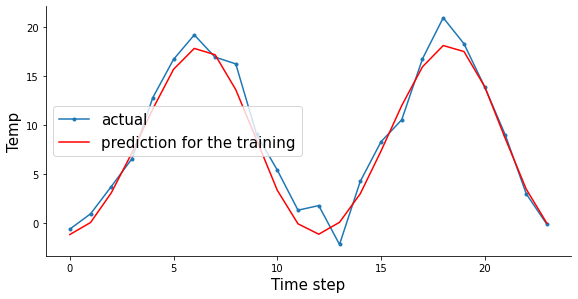

In [54]:
# validation

pred_plot_train = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France prediction plot train\\"

import seaborn as sns

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, inversed_original_train['avg_temp'].values[:24], marker='.', label="actual") 
plt.plot(aa, train_prediction['y_hat_train'].values[:24], 'r', label="prediction for the training")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig(pred_plot_train+f'{region_name} train.png')
plt.show();

### Predicting the validation set and getting the inverse 

In [55]:
valid_y_hat = saved_model.predict(X_valid_rolled)

In [56]:
# convert the prediction to dataframe to be added to the original
#I'm doing this because scaler is fit on a (n,4) shape and predition is only (n,1)
valid_y_hat = pd.DataFrame(valid_y_hat)

In [57]:
valid_y_hat = valid_y_hat.rename(columns = {0:'y_hat_valid'})

In [58]:
for_inverse_scaling_valid = combined_data[373+look_back:467] # valid set

In [67]:
combined_data[373+look_back:467]

,year,avg_temp,month_sin,month_cos
date,,,,
2013-03-01,0.800,0.155483,0.933013,0.750000
2013-04-01,0.800,0.269067,1.000000,0.500000
2013-05-01,0.800,0.490344,0.933013,0.250000
2013-06-01,0.800,0.564321,0.750000,0.066987
2013-07-01,0.800,0.736498,0.500000,0.000000
2013-08-01,0.800,0.872013,0.250000,0.066987
2013-09-01,0.800,0.806547,0.066987,0.250000
2013-10-01,0.800,0.688380,0.000000,0.500000
2013-11-01,0.800,0.585925,0.066987,0.750000


In [59]:
for_inverse_scaling_valid['y_hat_valid'] = valid_y_hat['y_hat_valid'].values
for_inverse_scaling_x_valid = for_inverse_scaling_valid[['year','y_hat_valid','month_sin','month_cos']]

In [60]:
inverse_scaling_x_valid = scaler.inverse_transform(for_inverse_scaling_x_valid)

In [61]:
valid_prediction = pd.DataFrame(inverse_scaling_x_valid).rename(columns = {0:'year',1:'y_hat_valid',2:'month_sin',3:'month_cos'})

In [62]:
# get the original valid data
original_valid = for_inverse_scaling_valid[['year','avg_temp','month_sin','month_cos']]

In [63]:
# inverse the original valid set
inversed_original_valid = scaler.inverse_transform(original_valid)

In [64]:
# put the original valid in dataframe 
inversed_original_valid = pd.DataFrame(inversed_original_valid).rename(columns = {0:'year',1:'avg_temp',2:'month_sin',3:'month_cos'})

In [65]:
print('valid Mean Absolute Error:', mean_absolute_error(inversed_original_valid['avg_temp'].values,valid_prediction['y_hat_valid'].values))
print('valid Root Mean Squared Error:',np.sqrt(mean_squared_error(inversed_original_valid['avg_temp'].values,valid_prediction['y_hat_valid'].values)))

valid Mean Absolute Error: 1.3689432542662066
valid Root Mean Squared Error: 1.7561903422681762


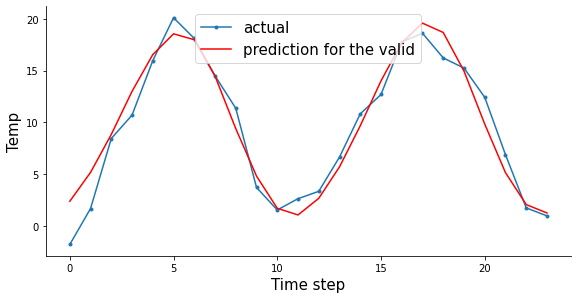

In [66]:
# valid

pred_plot_valid = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France prediction plot valid\\"

import seaborn as sns

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, inversed_original_valid['avg_temp'].values[:24], marker='.', label="actual") 
plt.plot(aa, valid_prediction['y_hat_valid'].values[:24], 'r', label="prediction for the valid")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig(pred_plot_valid+f'{region_name} valid.png')
plt.show();

In [68]:
# plot residuals for training

#inversed_original_train['avg_temp'].values,train_prediction['y_hat_train']


original_y_train =  inversed_original_train['avg_temp'] #y
prediction_train = train_prediction['y_hat_train']
df_residual_train = pd.concat([original_y_train,prediction_train], axis = 1)
df_residual_train['residual'] = df_residual_train['avg_temp'] - df_residual_train['y_hat_train']


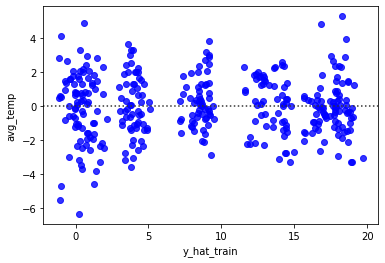

In [69]:
# plot residuals for training
resid_train = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France residual plots train\\"
sns_plot = sns.residplot(x ='y_hat_train', y = 'avg_temp', data = df_residual_train, color = 'blue')
sns_plot.figure.savefig(resid_train+f'{region_name} train residual.png')

In [70]:
# plot residuals for validation 

#inversed_original_valid['avg_temp'].values,valid_prediction['y_hat_valid'].values

original_y_valid = inversed_original_valid['avg_temp']
prediction_valid = valid_prediction['y_hat_valid']
df_residual_valid = pd.concat([original_y_valid,prediction_valid], axis = 1)
df_residual_valid['residual'] = df_residual_valid['avg_temp'] - df_residual_valid['y_hat_valid']


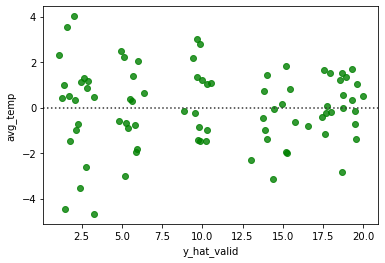

In [71]:
resid_valid = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France residual plots valid\\"

sns_plot_valid = sns.residplot(x ='y_hat_valid', y = 'avg_temp', data = df_residual_valid, color = 'green')
sns_plot_valid.figure.savefig(resid_valid+f'{region_name} valid residual.png')

# Predicting the future dates 

In [72]:
test_set = combined_data[455:] # test set look back of 12 which means use all months in 2019

In [73]:
test_set.head()

,year,avg_temp,month_sin,month_cos
date,,,,
2019-01-01,0.95,0.309984,0.500000,1.000000
2019-02-01,0.95,0.201309,0.750000,0.933013
2019-03-01,0.95,0.317185,0.933013,0.750000
2019-04-01,0.95,0.429787,1.000000,0.500000
2019-05-01,0.95,0.512275,0.933013,0.250000


In [74]:
# for loop over to 

pred_list = []
forecast_months = 24 # 2020-2021

prediction = 0

for row in range(forecast_months):
    #print(row)
    look_back = 12
    look_back_set = test_set[row:look_back+row] # [0:12]
    if row != 0:
        look_back_set.iloc[11][1] = prediction
    #print(counter)
    #display(test_set)
    x_test_reshaped = look_back_set.values.reshape(1,12,4)
    predict = saved_model.predict(x_test_reshaped)
    prediction = predict[0][0] ## append this to the next test set
    pred_list.append(prediction) 
    

In [75]:
test_set_prediction = pd.DataFrame(pred_list).rename(columns = {0:'prediction'})
test_set[12:]['avg_temp'] =  test_set_prediction['prediction'].values

In [76]:
inverse_test_prediction = test_set[12:][['year','avg_temp','month_sin','month_cos']]

In [77]:
inverse_test_prediction = scaler.inverse_transform(inverse_test_prediction)

In [78]:
final_prediction = pd.DataFrame(inverse_test_prediction).rename(columns = {0:'year',1:'predicted_temp',2:'month_sin',3:'month_cos'})

In [80]:
temp_prediction_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France Predictions\\"
display(final_prediction)
final_prediction.to_excel(temp_prediction_path+f' {region_name}.xlsx')

,year,predicted_temp,month_sin,month_cos
0,2020.0,2.641566,0.000000e+00,1.000000e+00
1,2020.0,1.973856,5.000000e-01,8.660254e-01
2,2020.0,3.552022,8.660254e-01,5.000000e-01
3,2020.0,6.589170,1.000000e+00,0.000000e+00
4,2020.0,10.476854,8.660254e-01,-5.000000e-01
5,2020.0,14.687799,5.000000e-01,-8.660254e-01
6,2020.0,18.371357,2.220446e-16,-1.000000e+00
7,2020.0,20.236706,-5.000000e-01,-8.660254e-01
8,2020.0,19.471716,-8.660254e-01,-5.000000e-01
9,2020.0,15.957619,-1.000000e+00,-2.220446e-16
